In [1]:
from models.classification_model import ClassifierModel # class with classifiers
from models.reduce_model import ReduceModel # class with autoencoder

import numpy as np
import pandas as pd

from sklearn import metrics
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt 
from cycler import cycler
# ide_plot() #plot for github dark theme

In [2]:
plt.rcParams["axes.facecolor"] = 'w'
plt.rcParams["figure.facecolor"] = 'w'
plt.rcParams['figure.dpi'] = 100
plt.rcParams["axes.spines.right"] = True
plt.rcParams["axes.spines.top"] = True
plt.rcParams["axes.edgecolor"] = 'black'
plt.rcParams["xtick.color"] = 'black'
plt.rcParams["ytick.color"] = 'black'
plt.rcParams["axes.labelcolor"] = 'black'
plt.rcParams["grid.color"] = 'black'
plt.rcParams["legend.frameon"] = False
plt.rcParams["legend.labelcolor"] = 'black'
plt.rcParams["axes.titlecolor"] = 'black'
plt.rcParams['axes.prop_cycle'] = cycler(color=['g', 'r', 'b', 'y'])

In [3]:
# Load main dataset
dataset = pd.read_csv("preprocessing/datasets/main_dataset.csv", index_col=0)
target = pd.read_csv("preprocessing/datasets/main_target.csv", index_col=0)

In [4]:
# train AE
reduce_model = ReduceModel(layers=(1018, 300, 10))
reduce_model.train(epochs=80, lr=1e-3)

Sequential(
  (0): Linear(in_features=1018, out_features=300, bias=True)
  (1): Sigmoid()
  (2): Linear(in_features=300, out_features=10, bias=True)
)
Sequential(
  (0): Linear(in_features=10, out_features=300, bias=True)
  (1): Sigmoid()
  (2): Linear(in_features=300, out_features=1018, bias=True)
)


  0%|          | 0/80 [00:00<?, ?it/s]

100%|██████████| 80/80 [00:31<00:00,  2.55it/s]

Epoch 80, Train Loss: 0.0015522374627873936
Epoch 80, Validation Loss: 0.0015424711931932796


In [5]:
cm = 1/2.54

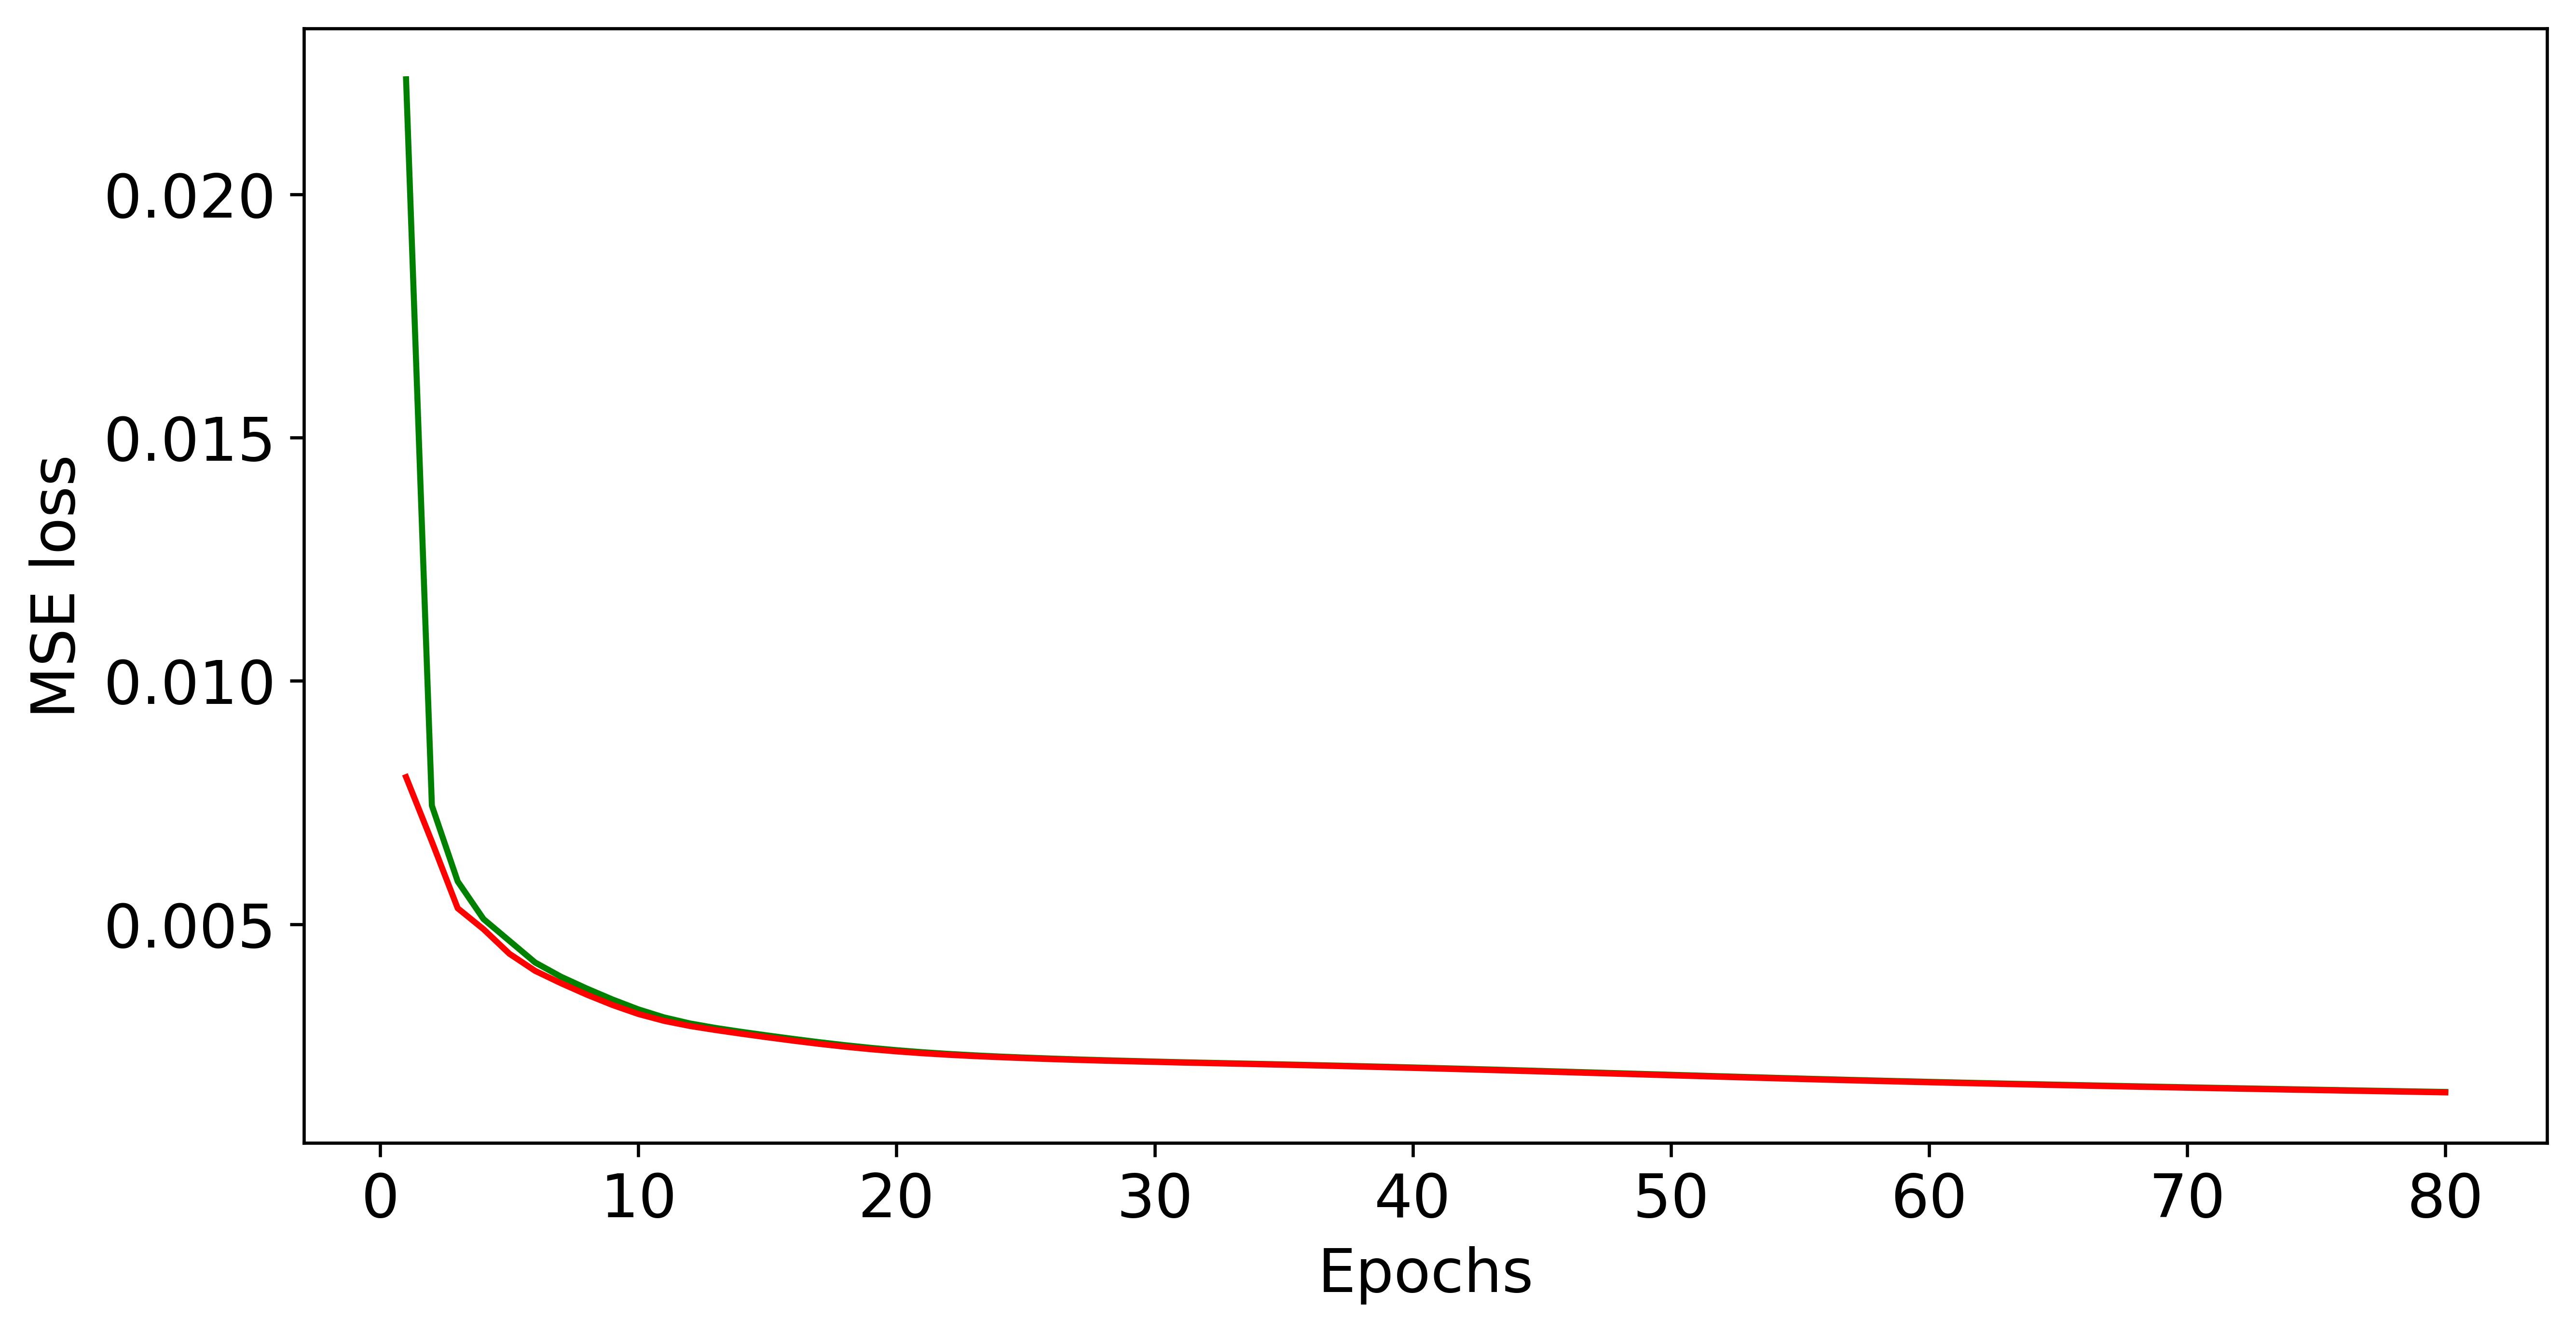

In [6]:
# load results
train_res = reduce_model.train_results
# plot results
plt.figure(figsize=(10, 5), dpi=600)
plt.plot(range(1, train_res["epochs"]+1), train_res["train_loss_list"])
plt.plot(range(1, train_res["epochs"]+1), train_res["test_loss_list"])
plt.ylabel("MSE loss", size=15)
plt.xlabel("Epochs", size=15)
plt.tick_params(labelsize=15)
# plt.savefig("ae_train.pdf")

In [7]:
# reduce main dataset
main_reduced = pd.DataFrame(reduce_model.transform(dataset), index=dataset.index)
# reduce QMOF
qmof_reduced = reduce_model.transform(reduce_model.dataset.cpu())

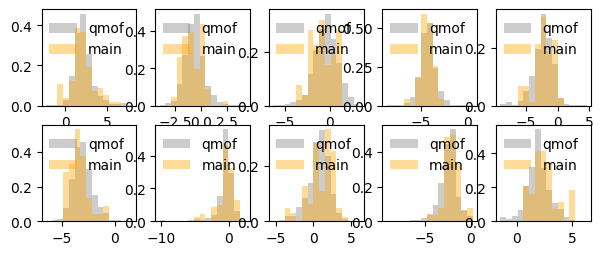

In [8]:
# plot distribution of reduced dimensions
fig, axes = plt.subplots(2, 5, figsize=(15,7))
u = 0
for i in range(2):
    for h in range(5):
        v, bins, p = axes[i,h].hist(qmof_reduced[:, u], density=True, bins=15, alpha=0.4, label="qmof", color='gray')
        axes[i,h].hist(main_reduced.values[:, u], density=True, bins=bins, alpha=0.4, label="main", color='orange')
        axes[i,h].legend()
        u += 1
    

# Classification

In [9]:
X_train, X_test, y_train, y_test = train_test_split(
    main_reduced, target, test_size=0.2, random_state=41,
    stratify=target.values.ravel()
    )

scaler = RobustScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
qmof_reduced_scaled = scaler.transform(qmof_reduced)

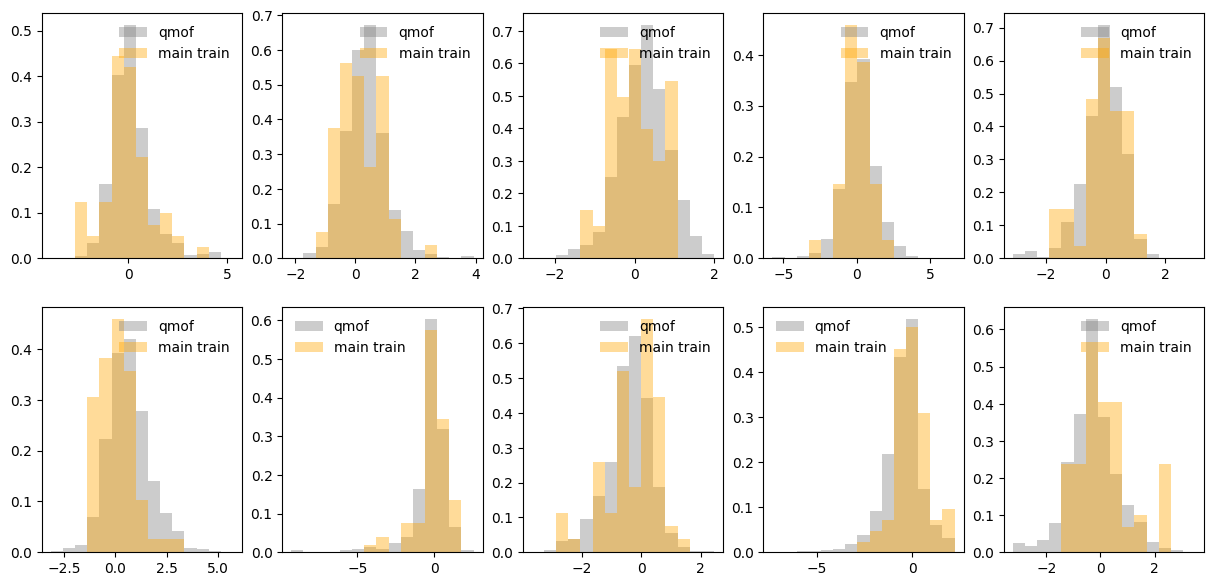

In [10]:
# plot scaled distribution

fig, axes = plt.subplots(2, 5, figsize=(15,7))
u=0
for i in range(2):
    for j in range(5):
        v, bins, p = axes[i,j].hist(qmof_reduced_scaled[:, u], density=True, bins=15, alpha=0.4, label="qmof", color='gray')
        axes[i,j].hist(X_train[:, u], density=True, bins=bins, alpha=0.4, label="main train", color='orange')
        axes[i,j].legend()
        u+=1
# plt.savefig("distribution_scaled.svg")

In [11]:
# CV + optimize

c_model = ClassifierModel()
res = c_model.cv(pd.DataFrame(X_train), pd.DataFrame(y_train), time_per_clf=10)

evaluate CatBoost
  0%|          | 0/9223372036854775807 [00:00<?, ?trial/s, best loss=?]

  0%|          | 121/9223372036854775807 [00:10<212851235229518:53:52, 12.04trial/s, best loss: -0.7608391608391608]
best depth ber folds: [2, 2, 3, 4, 4]
best n_estimators ber folds: [43, 50, 59, 56, 38]
best learning_rate ber folds: [1.6349956882944085e-05, 7.669058616122505e-05, 1.1072465220639398e-05, 0.0008366696036806422, 1.2327615119143807e-05]
best l2_leaf_reg ber folds: [0.12706236483178754, 0.010315547951208886, 0.08292335880585225, 0.08579378917595509, 0.38284468895986695]
evaluate RF
  0%|          | 143/9223372036854775807 [00:10<179730980505685:37:04, 14.25trial/s, best loss: -0.6886446886446886]
best max_depth ber folds: [7, 8, 9, 10, 6]
best n_estimators ber folds: [50, 22, 48, 50, 41]
evaluate AdaBoost
  0%|          | 90/9223372036854775807 [00:10<287480237737215:57:52,  8.91trial/s, best loss: -0.846153846153846] 
best max_depth ber folds: [5, 11, 11, 7, 4]
best n_estimators ber folds: [54, 43, 57, 50, 59]
best learning_rate ber folds: [0.000529464373046793, 7.034879

In [12]:
for name in res:
    print(f"Classifier: {name}")
    for param in res[name]:
        if param != "balance":
            print(f"{param}\t: {res[name][param]}")
    print(f"Fold count of class samples: {res[name]['balance']}")

Classifier: CatBoost
depth	: 4
l2_leaf_reg	: 0.38284468895986695
learning_rate	: 1.2327615119143807e-05
n_estimators	: 38
score	: 0.7608391608391608
Fold count of class samples: {'test': {'0': 6, '1': 7}, 'train': {'0': 23, '1': 30}}
Classifier: RF
max_depth	: 8
n_estimators	: 22
score	: 0.8288461538461539
Fold count of class samples: {'test': {'0': 5, '1': 8}, 'train': {'0': 24, '1': 29}}
Classifier: AdaBoost
learning_rate	: 0.0007522056600419445
max_depth	: 4
n_estimators	: 59
score	: 0.846153846153846
Fold count of class samples: {'test': {'0': 6, '1': 7}, 'train': {'0': 23, '1': 30}}
Classifier: kNN
n_neighbors	: 4
score	: 0.726998491704374
Fold count of class samples: {'test': {'0': 5, '1': 8}, 'train': {'0': 24, '1': 29}}


In [13]:
# set params and fit for scoring
c_model.set_params({name: {param: res[name][param] for param in res[name] if param not in (
    "balance", "score")} for name in res})



In [14]:
c_model.fit(X_train, y_train.values.ravel())

In [15]:
for name in c_model.models:
    pred = c_model.models[name].predict(X_test)
    print(f"report for {name}: {c_model.score(y_test, pred):.2f}")
    print(metrics.classification_report(y_test, pred))

report for CatBoost: 0.66
              precision    recall  f1-score   support

           0       1.00      0.38      0.55         8
           1       0.64      1.00      0.78         9

    accuracy                           0.71        17
   macro avg       0.82      0.69      0.66        17
weighted avg       0.81      0.71      0.67        17

report for RF: 0.69
              precision    recall  f1-score   support

           0       0.80      0.50      0.62         8
           1       0.67      0.89      0.76         9

    accuracy                           0.71        17
   macro avg       0.73      0.69      0.69        17
weighted avg       0.73      0.71      0.69        17

report for AdaBoost: 0.58
              precision    recall  f1-score   support

           0       0.57      0.50      0.53         8
           1       0.60      0.67      0.63         9

    accuracy                           0.59        17
   macro avg       0.59      0.58      0.58        17
we

In [16]:
def roc_auc_plot(ax, clf_model: ClassifierModel, x_test, y_test):
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(2)
    lw = 2
    ax.plot()
    for clf in clf_model.models:
        pred_proba = clf_model.models[clf].predict_proba(x_test)
        fpr, tpr, threshold = metrics.roc_curve(y_test, pred_proba[:,1])
        auc = metrics.auc(fpr, tpr)
        ax.plot(fpr,
                 tpr,
                 linestyle='--',
                 label=f"ROC curve {clf} (area={auc:.2f})")
    ax.plot([0, 1], [0, 1], color="purple", lw=lw, linestyle="--")
    ax.set_xlim([-0.01, 1.0])
    ax.set_ylim([0.0, 1.01])
    ax.set_xlabel("False Positive Rate", size=15)
    ax.set_ylabel("True Positive Rate", size=15)
    #ax.set_title("Receiver operating characteristic example", size=15)
    ax.legend(loc="lower right", fontsize=15)
    ax.tick_params(axis='both',label1On=True, size=5, labelsize=15)
    # plt.show()

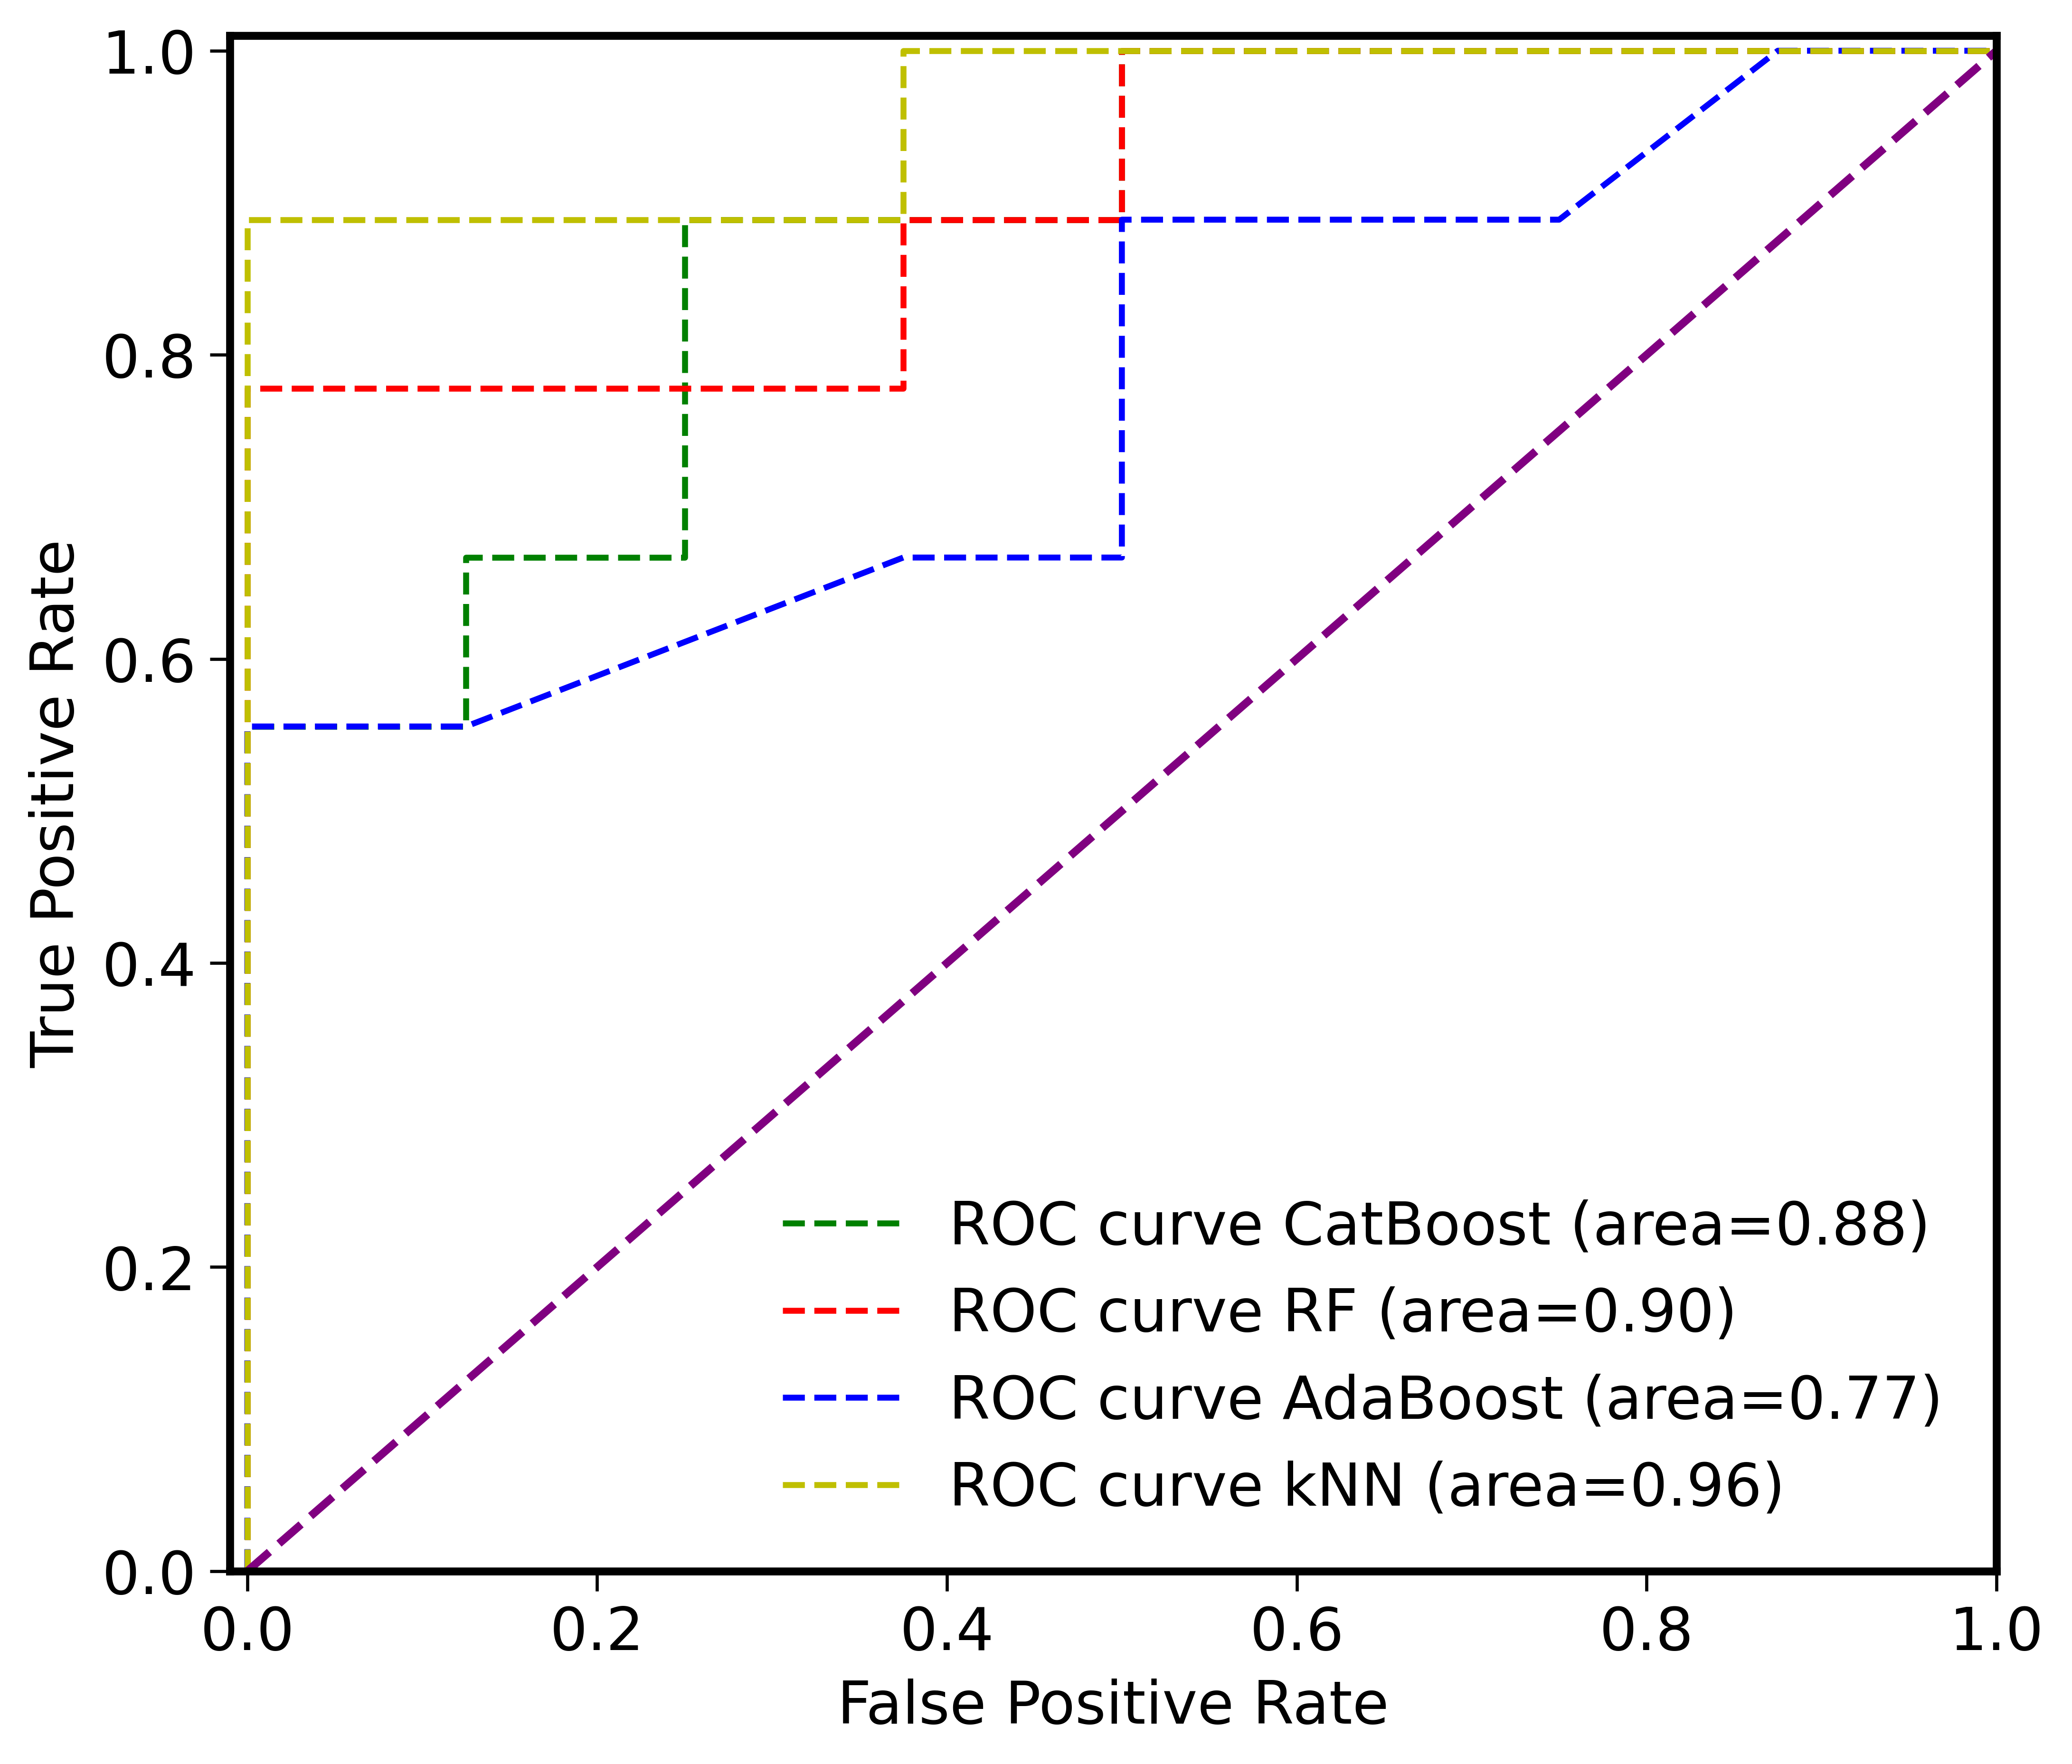

In [17]:
f, a = plt.subplots(1, 1, figsize=(8, 7), dpi=600)

roc_auc_plot(a, c_model, X_test, y_test)
# plt.savefig("roc_auc.pdf")

In [18]:
# fir model on all samples
c_model.fit(scaler.transform(main_reduced), target.values.ravel())

In [19]:
import joblib

joblib.dump(reduce_model, "models/best/reduce_model.pkl")

joblib.dump(c_model, "models/best/c_model.pkl")

joblib.dump(res, "models/best/best_params.pkl")

joblib.dump(scaler, "models/best/scaler.pkl")




['models/best/scaler.pkl']